### Air Pollution Study Using EPA Data

The study below looks at air quality in the U.S. between 2004 and 2014 using selected data from the EPA, available at http://aqsdr1.epa.gov/aqsweb/aqstmp/airdata/download_files.html. Specifically, we look at PM 2.5 data, which refers to particulate matter less than or equal to 2.5 microns in size, also called fine particle pollution.

The goal is to see how pollution levels have changed during the period of interest, both nationwide and for individual states.


In [15]:
import numpy as np
import pandas as pd

# For 2004, starting at row 150656, the State Code switches from an integer to 'CC', 
# indicating Canada, so we need to skip those. For both years, we'll parse the
# dates, which are at column 11.
skip = range(150656, 150771)
data2004 = pd.read_csv('Data/daily_88101_2004.csv', skiprows=skip, parse_dates=[11])
data2014 = pd.read_csv('Data/daily_88101_2014.csv', parse_dates=[11])

In [169]:
# Create subsets of the data, with just the columns we care about.
d2004 = data2004.loc[:, ['State Code','County Code','Site Num','Latitude','Longitude','Date Local', \
                 'AQI','State Name','County Name', 'City Name']]
d2014 = data2014.loc[:, ['State Code','County Code','Site Num','Latitude','Longitude','Date Local', \
                 'AQI','State Name','County Name', 'City Name']]

The feature we are most interested in is the Air Quality Index (AQI), recorded as an integer that ranges from 0 to greater than 300, measured in micrograms per cubic meter. Here is how the EPA defines the air quality for ranges of AQI:
- 0–50: "Good"
- 51–100: "Moderate"
- 101–150: "Unhealthy for Sensitive Groups"
- 151–200: "Unhealthy"
- 201–300: "Very Unhealthy"
- Above 300: "Hazardous"


In [36]:
# Create a summary dataframe of the AQI data for the two years
AQI = pd.DataFrame([d2004.describe().loc[['min', 'max', 'mean'], 'AQI'], 
                    d2014.describe().loc[['min', 'max', 'mean'], 'AQI']], ['2004', '2014'])
AQI

,min,max,mean
2004,0,503,44.203364
2014,0,240,34.231220


Just based on this cursory summary, it looks like there's been improvement over the last ten years, i.e., a reduction in the amount of PM 2.5 measured. But let's look deeper and make some graphs.

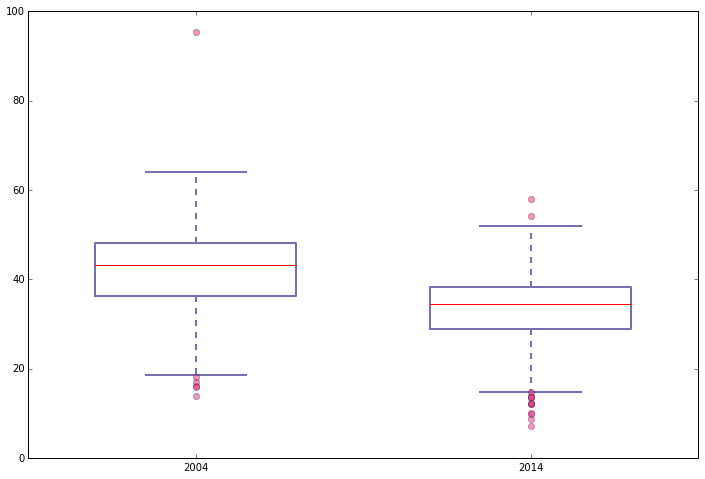

In [88]:
import matplotlib.pyplot as plt
%matplotlib inline

# Rather than use all the points, we'll group the data by state and county, then get the means.
AQI_mean_2004 = d2004.groupby(['State Code', 'County Code']).aggregate(np.mean)
AQI_mean_2014 = d2014.groupby(['State Code', 'County Code']).aggregate(np.mean)

AQI_2004 = np.array(AQI_mean_2004[['AQI']])
AQI_2014 = np.array(AQI_mean_2014[['AQI']])

# Create a figure instance
fig = plt.figure(1, figsize=(12, 8))
ax = fig.add_subplot(111)

# Create the boxplot
boxprops = dict(linestyle='-', linewidth=2, color='#7570b3')
medianprops = dict(linestyle='-.', color='#b2df8a', linewidth=2)
capprops = dict(color='#7570b3', linewidth=2)
flierprops = dict(marker='o', color='#e7298a', alpha=0.5)
whiskerprops = dict(color='#7570b3', linewidth=2)
meanpointprops = dict(marker='D', markeredgecolor='black',markerfacecolor='firebrick')

bp = ax.boxplot([AQI_2004, AQI_2014], widths=.6,
               boxprops=boxprops, flierprops=flierprops, 
               meanprops=meanpointprops, capprops=capprops,
               whiskerprops=whiskerprops)
ax.set_xticklabels(['2004', '2014'])

plt.show()

With the aggregated data, it looks like the pollutant levels have indeed gone down since 2004. However, there are two things to keep in mind:
- Pollutant levels vary over the seasons, and tend to be higher in the winter and late summer.
- Some states may have improved more than others.

Let's first look at how levels of PM 2.5 vary over the course of the year, for both 2004 and 2014.

In [170]:
# First, group by month and get the means.
grouped2004 = d2004.groupby([pd.DatetimeIndex(d2004['Date Local']).month]).aggregate(np.mean)
grouped2014 = d2014.groupby([pd.DatetimeIndex(d2014['Date Local']).month]).aggregate(np.mean)

# Create numpy arrays of just the AQI data
AQI_2004 = np.array(grouped2004['AQI'])
AQI_2014 = np.array(grouped2014['AQI'])


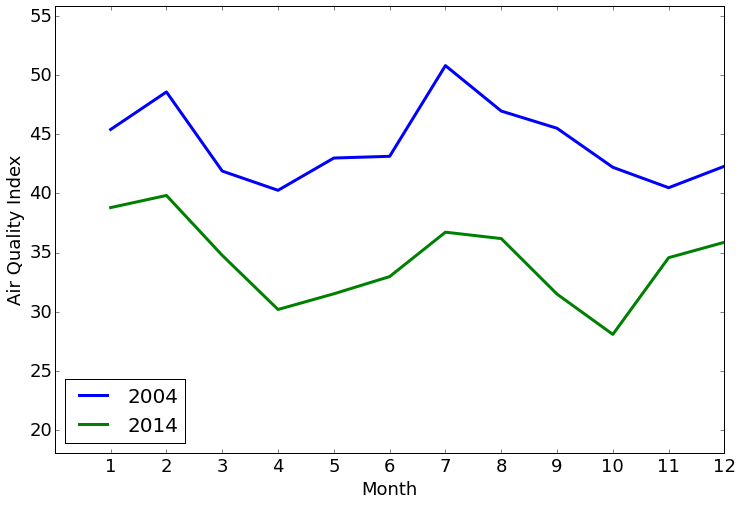

In [171]:
max_y = max(max(grouped2014['AQI']), max(grouped2004['AQI']))
min_y = min(min(grouped2014['AQI']), min(grouped2004['AQI']))

x = np.arange(1,13)

fig = plt.figure(2, figsize=(12, 8))
ax = fig.add_subplot(1,1,1)
plt.rc('font', weight='medium', size=18)
ax.set_ylim([min_y-10, max_y+5])
ax.set_xlabel('Month')
ax.set_ylabel('Air Quality Index')
ax.plot(x, AQI_2004, linewidth = 3, label='2004')
ax.plot(x, AQI_2014, linewidth = 3, label='2014')
plt.xticks(range(1, 13), np.arange(1, 13))
ax.legend(loc='lower left', fontsize=20)
plt.show()


Great! We seem to see improvement in each month when we compare 2014 with 2004. Next, we want to see how the individual states have done. Note that this includes Washington, DC, Puerto Rico, and the U.S. Virgin Islands.

In [130]:
grouped2004 = d2004.groupby(d2004['State Code']).aggregate(np.mean)
grouped2014 = d2014.groupby(d2014['State Code']).aggregate(np.mean)

# Create numpy arrays of just the AQI data
AQI_2004 = np.array(grouped2004['AQI'])
AQI_2014 = np.array(grouped2014['AQI'])

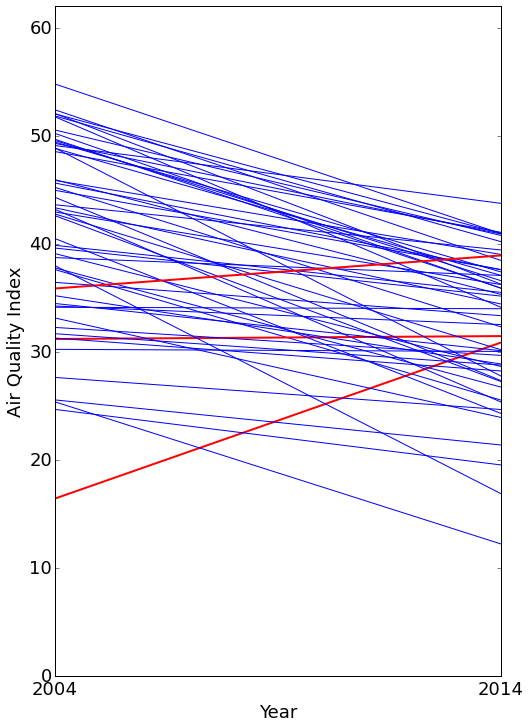

In [156]:
max_y = max(max(grouped2014['AQI']), max(grouped2004['AQI']))
min_y = min(min(grouped2014['AQI']), min(grouped2004['AQI']))

# Create single data frame
AQI = pd.DataFrame([pd.Series(AQI_2004), pd.Series(AQI_2014)], ['2004','2014'])
AQI = AQI.T

fig = plt.figure(3, figsize=(8, 12))
ax = fig.add_subplot(1,1,1)
plt.rc('font', weight='medium', size=18)
ax.set_ylim([0, max_y])

# Plot each line, where a thick red line indicates an increase in AQI
for i, row in AQI.iterrows():
    if row['2014'] > row['2004']:
        ax.plot(AQI.columns, row, color='red', linewidth=2)
    else: 
        ax.plot(AQI.columns, row, color='blue', linewidth=1)

plt.xticks([2004,2014], ['2004','2014'])
ax.set_xlabel('Year')
ax.set_ylabel('Air Quality Index')

In [189]:
# Let's remove the outlying areas: Alaska, Hawaii, V.I. and Puerto Rico.
# Then group by the state name so we can make a bubble graph.
d2014_2 = d2014[(d2014['State Code'] < 57) & (d2014['State Code'] !=2) & (d2014['State Code'] !=15)]
grouped2014_2 = d2014_2.groupby(d2014_2['State Name']).aggregate(np.mean)

# Still to do:
# - Add a column of state abbreviations
# - figure out how to change the colors of the bubbles based on AQI value

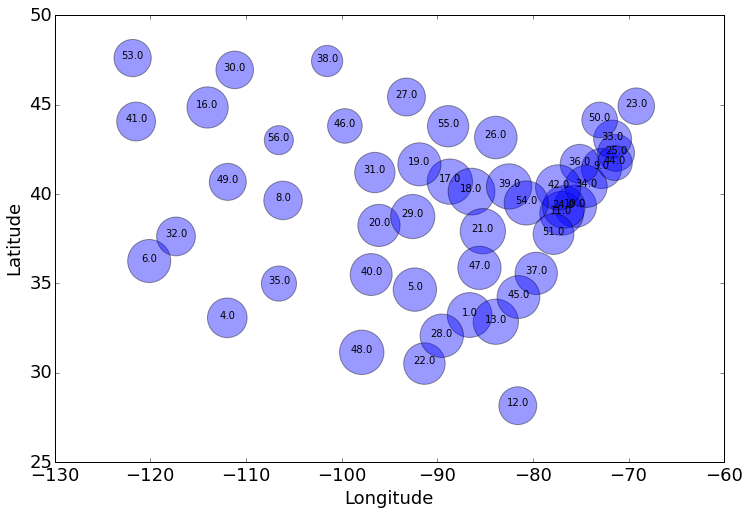

In [196]:
# 2014 bubble plot based on location and AQI levels
fig = plt.figure(figsize=(12, 8))        
ax = fig.add_subplot(111)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

scatter = ax.scatter(
    grouped2014_2['Longitude'], 
    grouped2014_2['Latitude'], 
    
    s=50*grouped2014_2['AQI'],
    linewidths=1, 
    edgecolor='k',
    alpha=0.4
)

for i, row in grouped2014_2.iterrows():
    plt.text(
        row['Longitude'],
        row['Latitude'],
        row['State Code'], 
        size=10,
        horizontalalignment='center'
    )
plt.show()